##  ReAct Agent

### Tools

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
arxiv

ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500))

In [4]:
arxiv.invoke("attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [3]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\Crist\\Documents\\projects\\llm_practices\\1-LangChain\\LangGraph\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=500))

In [5]:
wiki.invoke("What's machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv("./.emv")

import os

os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "ReAct_Agent"

In [7]:
### Custom Functions
def multiply(a:int, b:int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a:int, b:int) -> int:
    """Adds a and b
    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a:int, b:int) -> float:
    """ Divide a and b.
    Args:
        a: first int
        b: second int
    """
    return a/b

tools = [arxiv, wiki, multiply, add, divide]

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\Crist\AppData\Local\Temp\ipykernel_14236\735679136.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [9]:
tavily.invoke("What are the leates AI news")

[{'title': 'The Latest AI News and AI Breakthroughs that Matter Most: 2025',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': '### _(AI Breakthrough)_ Microsoft Unveils Two AI Models: MAI‑Voice‑1 and MAI‑1 Preview\n\nDate: August 29, 2025\n\nSummary: Microsoft introduced its first proprietary AI models: MAI‑Voice‑1, capable of generating a minute of audio in under a second with minimal compute, and MAI‑1 Preview, a foundational LLM now available for public testing on LMArena. These models signal Microsoft’s strategic pivot from relying on OpenAI to building its own AI stack for future products. [...] Date: October 12, 2025Summary: Meta has poached Andrew Tulloch, co‑founder of the startup Thinking Machines Lab, with a compensation package rumored to reach $1.5 billion over six years. The move underscores Meta’s aggressive strategy to close the AI gap with OpenAI, Google, and Anthropic by acquiring top talent rather than just technology. Tulloch’s transi

In [10]:
tools.append(tavily)

### LLM

In [13]:
## Initialize LLM Model
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-20b")

llm_with_tools = llm.bind_tools(tools)

In [14]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage

In [17]:
response = llm_with_tools.invoke([HumanMessage(content="Leatest AI news")])

In [18]:
response.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest AI news'},
  'id': 'fc_827b807d-0d74-47dc-96cd-c6ecd8973871',
  'type': 'tool_call'}]

### State Schema

In [20]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

### LangGraph

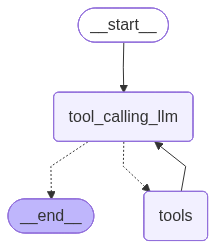

In [23]:
from IPython.display import display,Image
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode, tools_condition

# Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
messages = graph.invoke({"messages":[HumanMessage(content="Get the top 10 leatest AI now as october 18th 2025, add 5 plus 5 and then multipy by 10")]})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Get the top 10 leatest AI now as october 18th 2025, add 5 plus 5 and then multipy by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_80af75eb-24b7-44f6-af24-2952c8465918)
 Call ID: fc_80af75eb-24b7-44f6-af24-2952c8465918
  Args:
    query: top 10 latest AI models 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top 10 LLMs Summer 2025 Edition - Azumo", "url": "https://azumo.com/artificial-intelligence/ai-insights/top-10-llms-0625", "content": "## Top 10 Large Language Models: A Comprehensive Comparison for September 2025\n\nThe large language model landscape continues to evolve at breakneck speed, with 2025 marking a pivotal year for AI capabilities, efficiency, and accessibility. From Claude 4's breakthrough coding performance to Gemini 2.5 Pr

In [30]:
messages = graph.invoke({"messages":[HumanMessage(content="Current Guatemala's president")]})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

Current Guatemala's president
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_4fa3768e-e134-4a86-8e81-870b04841b86)
 Call ID: fc_4fa3768e-e134-4a86-8e81-870b04841b86
  Args:
    query: Bernardo Arévalo Guatemala president 2024
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Inauguration of Bernardo Arévalo - Wikipedia", "url": "https://en.wikipedia.org/wiki/Inauguration_of_Bernardo_Ar%C3%A9valo", "content": "The inauguration of Bernardo Arévalo as the 52nd president of Guatemala on Monday, 15 January 2024 marked the commencement of the four-year term of Bernardo Arévalo as president and Karin Herrera as vice president. [...] | Bernardo Arévalo taking the oath of office as the 52nd president of Guatemala. | |\n| Date | 15 January 2024 |\n| Location | C

In [32]:
messages = graph.invoke({"messages":[HumanMessage(content="What's 10 divided by 3")]})
for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

What's 10 divided by 3
================================== Ai Message ==================================

10 divided by 3 is approximately **3.333 333 333 …** (i.e., 3 ⅓).
